In [35]:
import pandas as pd
import talib
import os
import logging
import time
import numpy as np
import datetime as dt
import backtrader as bt
import pandas as pd
import itertools
from backtrader_plotting import Bokeh
from backtrader_plotting.schemes import Tradimo
#%matplotlib qt
%matplotlib inline

In [2]:
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(name)s - %(levelname)s - %(message)s')
logger = logging.getLogger("study")
handler = logging.FileHandler('study.log')
formatter = logging.Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s')
handler.setFormatter(formatter)
logger.addHandler(handler)

In [3]:
stock_data_store = pd.HDFStore(r'E:\project\trade_engine\data_processing\quandl_data_processor\stock_day.h5')

# 取出所有volume>3000000的股票的symbol组成一个list
symbol_list = pd.read_csv(
    r"E:\project\trade_engine\data_processing\quandl_data_processor\filter_stock_symbols.csv").loc[
              :, "symbols"].tolist()

# 用一个字典来把所有股票数据全部读到内存中去.
symbol_frame_dict = {}
for symbol in symbol_list:
    # 从hdf中把数据读进内存中
    symbol_frame = stock_data_store.select('day', where=['symbol=="{}"'.format(symbol)])
    # 我们只研究2000年后的股票数据, 之前的就不要了
    symbol_frame = symbol_frame[symbol_frame.index > dt.datetime(2000, 1, 1)]
    # 把数据缓存到一个字典中, symbol作为key
    symbol_frame_dict[symbol] = symbol_frame

2021-01-29 01:22:57,007 - numexpr.utils - INFO - Note: NumExpr detected 12 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
2021-01-29 01:22:57,009 - numexpr.utils - INFO - NumExpr defaulting to 8 threads.


In [48]:
# 首先要定义一个param list
param_name_list = ["m", "n", "min_price", "float_factor", "high_factor"]

# 在此定义策略中的所有参数取值范围, 用list数据结构
param_value_selections = [
    [5],
    [25],
    [5],
    [0.08],
    [0.8]
]


# 循环所有的参数可能的组合
for param_values in itertools.product(*param_value_selections):
    # 把当前所有params的取值放在一个字典中
    param = {}
    for index, param_name in enumerate(param_name_list):
        param[param_name] = param_values[index]

In [49]:
param

{'m': 5, 'n': 25, 'min_price': 5, 'float_factor': 0.08, 'high_factor': 0.8}

In [50]:
# 创建一个list用于记录计算出的所有股票的buy signal data frame
buy_signal_list = []

# 创建一个list用于记录计算出的所有股票的buy signal data frame
buy_signal_list = []
for symbol in symbol_list:
    # 首先从内存中取出数据
    data = symbol_frame_dict[symbol]

    # 下面计算一些指标
    close = data.loc[:, "adj_close"]
    adj_close_change = (close - close.shift(1)) / close.shift(1)
    close_change_m_days_max = close.shift(1).rolling(param["m"]).max()
    close_change_m_days_max_percent = (close_change_m_days_max - close) / close

    close_change_m_days_min = close.shift(1).rolling(param["m"]).min()
    close_change_m_days_min_percent = (close_change_m_days_min - close) / close

    previous_high = close.shift(1).rolling(param["m"] + param["n"]).max()
    previous_high_percent = (previous_high - close) / close

    close_greater_than_min_price = (close > param["min_price"]) * 1

    # 根据指标计算买入信号.
    buy_signal = (
            (close_change_m_days_max_percent < param["float_factor"])
            & (close_change_m_days_min_percent > -param["float_factor"])
            & (previous_high_percent > param["high_factor"])
            & (close_greater_than_min_price == 1)
            & (close > close_change_m_days_max)
    )

    # 计算未来多少天的收益值
    next_7_days_avg_close_change = adj_close_change.rolling(7).mean().shift(-7)
    next_14_days_avg_close_change = adj_close_change.rolling(14).mean().shift(-14)
    next_21_days_avg_close_change = adj_close_change.rolling(21).mean().shift(-21)
    next_28_days_avg_close_change = adj_close_change.rolling(28).mean().shift(-28)

    # 构建buy signal dataframe
    buy_sig_index = buy_signal[buy_signal == True].index
    buy_signal_frame = pd.concat([
        data.loc[buy_sig_index],
        next_7_days_avg_close_change.loc[buy_sig_index].rename("next_7_days_avg_close_change"),
        next_14_days_avg_close_change.loc[buy_sig_index].rename("next_14_days_avg_close_change"),
        next_21_days_avg_close_change.loc[buy_sig_index].rename("next_21_days_avg_close_change"),
        next_28_days_avg_close_change.loc[buy_sig_index].rename("next_28_days_avg_close_change")],
        axis=1
    )

    # 把当前symbol的buy signal list存储在 buy signal中
    buy_signal_list.append(buy_signal_frame)

# 把所有symbol的buy signal frame合成为一个summary buy signal frame
buy_signal_summary_frame = pd.concat(buy_signal_list)

In [39]:
buy_signal_summary_frame.to_csv("check.csv")

In [51]:
buy_signal_summary_frame.describe()

,unadj_open,unadj_high,unadj_low,unadj_close,unadj_vol,dividends,splits,adj_open,adj_high,adj_low,adj_close,adj_volume,next_7_days_avg_close_change,next_14_days_avg_close_change,next_21_days_avg_close_change,next_28_days_avg_close_change
count,508.000000,508.000000,508.000000,508.000000,5.080000e+02,508.000000,508.0,5.080000e+02,5.080000e+02,5.080000e+02,5.080000e+02,5.080000e+02,508.000000,508.000000,508.000000,506.000000
mean,12.536172,12.979242,12.370019,12.786263,3.751657e+06,0.000571,1.0,8.703597e+06,9.484509e+06,8.651360e+06,8.985571e+06,2.336845e+06,0.001119,-0.000295,-0.000369,0.003478
std,15.088341,15.556478,14.917524,15.345649,8.813515e+06,0.009095,0.0,1.791369e+08,1.959076e+08,1.787332e+08,1.858197e+08,5.374393e+06,0.033213,0.020693,0.016803,0.079123
min,0.058300,0.059000,0.055000,0.057100,0.000000e+00,0.000000,1.0,4.720000e+00,5.098059e+00,4.000000e+00,5.050000e+00,0.000000e+00,-0.189236,-0.150228,-0.120563,-0.091758
25%,2.080000,2.160000,2.022500,2.160000,2.190750e+05,0.000000,1.0,8.030000e+00,8.428000e+00,7.927324e+00,8.177817e+00,2.601048e+04,-0.010049,-0.007729,-0.006656,-0.006133
50%,7.538500,7.895000,7.440000,7.695000,1.066150e+06,0.000000,1.0,1.564000e+01,1.633250e+01,1.549000e+01,1.606500e+01,3.711000e+05,-0.001035,-0.001432,-0.000473,0.000138
75%,15.510000,16.260000,15.480000,16.055000,3.569493e+06,0.000000,1.0,4.164500e+01,4.305000e+01,4.126250e+01,4.267012e+01,2.622074e+06,0.008586,0.006639,0.005331,0.005776
max,115.910000,119.250000,115.230000,117.330000,1.340000e+08,0.150000,1.0,4.032006e+09,4.410007e+09,4.023438e+09,4.183206e+09,5.567406e+07,0.482652,0.222279,0.148186,1.755308


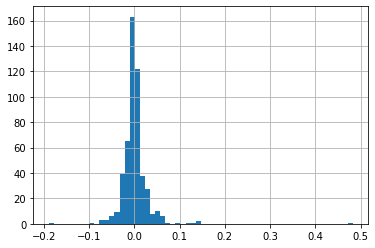

In [52]:
_ = buy_signal_summary_frame.loc[:, "next_7_days_avg_close_change"].hist(bins=60)

画图

In [172]:
cerebro = bt.Cerebro()
data = bt.feeds.PandasData(
    dataname=data,
    datetime=None,
    open=8,
    high=9,
    low=10,
    close=11,
    volume=12,
    openinterest=-1
)
cerebro.adddata(data)
cerebro.run()

In [173]:
cerebro.plot(style='candle', iplot=False)

[[<Figure size 640x480 with 4 Axes>]]

In [174]:
# b = Bokeh(style='bar') # 黑底, 单页
b = Bokeh(style='bar', tabs='multi') # 黑底, 多页
# b = Bokeh(style='bar', scheme=Tradimo()) # 传统白底, 单页
# b = Bokeh(style='bar', tabs='multi', scheme=Tradimo()) # 传统白底, 多页
cerebro.plot(b, iplot=False)

[[<backtrader_plotting.bokeh.bokeh.FigurePage at 0x1d79eb8bf60>]]